<a href="https://colab.research.google.com/github/dinaelmiari/Pneumothorax-CNN-Segmentation-using-X-Ray-Images/blob/main/Pneumothorax_CNN_Segmentation_using_X_Ray_Images_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Importing Libraries and Functions



In [ ]:
import matplotlib.pyplot as plt # for visualization
import numpy as np # for putting images in a format necessary for CNN
import cv2 # loading images and image processing
import os
import tensorflow as tf # library used for creation of CNN
import pathlib # data loading
from sklearn.model_selection import train_test_split # splitting data into training and testing datasets
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import random
import pathlib
import pandas as pd

# componenets used in creation of CNN model
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten,Input, Conv2D, MaxPooling2D,  Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam

# Load the data from my drive from folder archive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(os.listdir('/content/drive/My Drive/Imaging/archive/siim-acr-pneumothorax'))

# Define paths
train_csv_path = '/content/drive/My Drive/Imaging/archive/siim-acr-pneumothorax/stage_1_train_images.csv'
test_csv_path = '/content/drive/My Drive/Imaging/archive/siim-acr-pneumothorax/stage_1_test_images.csv'
images_path = '/content/drive/My Drive/Imaging/archive/siim-acr-pneumothorax/png_images'
masks_path = '/content/drive/My Drive/Imaging/archive/siim-acr-pneumothorax/png_masks'


['stage_1_test_images.csv', 'stage_1_train_images.csv', 'png_images', 'png_masks', 'stage_1_test_images.gsheet', 'stage_1_train_images.gsheet']


In [ ]:
# Load the CSV file
train_csv_path = "/content/drive/My Drive/Imaging/archive/siim-acr-pneumothorax/stage_1_train_images.csv"
train_info = pd.read_csv(train_csv_path)

# Filter images by target (e.g., 1 = affected, 0 = unaffected)
affected_images = train_info[train_info['has_pneumo'] == 1]['ImageId'].tolist()  # Images with pneumonia
unaffected_images = train_info[train_info['has_pneumo'] == 0]['ImageId'].tolist()  # Images without pneumonia


# Match images and masks using the file naming convention
image_filenames = sorted(os.listdir(images_path))  # Path to images folder
mask_filenames = sorted(os.listdir(masks_path))    # Path to masks folder

# Select affected and unaffected images (balance if needed)
affected_image_files = [f for f in image_filenames if f.split('_')[0] in affected_images]
unaffected_image_files = [f for f in image_filenames if f.split('_')[0] in unaffected_images]



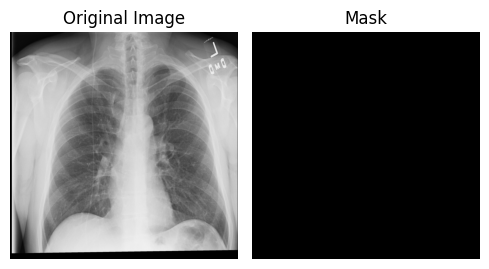

In [ ]:
# Get the first image and its corresponding mask
image_filename = os.listdir(images_path)[0]
mask_filename = os.listdir(masks_path)[0]

# Load the image and mask
image = cv2.imread(os.path.join(images_path, image_filename), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(os.path.join(masks_path, mask_filename), cv2.IMREAD_GRAYSCALE)

# Display the image and mask side by side
plt.figure(figsize=(5, 5))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Show the mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

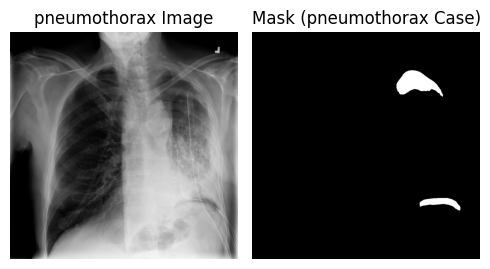

In [ ]:
# Find an pneumothorax image (non-zero mask)
pneumothorax_image_filename = None
pneumothorax_mask_filename = None

for image_filename, mask_filename in zip(sorted(os.listdir(images_path)), sorted(os.listdir(masks_path))):
    # Load the mask
    mask_path = os.path.join(masks_path, mask_filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the mask contains non-zero values (indicating an pneumothorax case)
    if mask.sum() > 0:
        pneumothorax_image_filename = image_filename
        pneumothorax_mask_filename = mask_filename
        break

if pneumothorax_image_filename and pneumothorax_mask_filename:
    # Load the corresponding image and mask
    image = cv2.imread(os.path.join(images_path, pneumothorax_image_filename), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(masks_path, pneumothorax_mask_filename), cv2.IMREAD_GRAYSCALE)

    # Display the pneumothorax image and its mask
    plt.figure(figsize=(5, 5))

    # Show the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("pneumothorax Image")
    plt.axis("off")

    # Show the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask (pneumothorax Case)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No pneumothorax cases found in the dataset!")


# Preproccesing

In [ ]:
# Parameters
SUBSET_SIZE = 7000
RESIZE_DIM = (256, 256)  # Resize dimensions

# Load the CSV
train_info = pd.read_csv(train_csv_path)

# Filter affected and unaffected images based on `has_pneumo`
affected_images = train_info[train_info['has_pneumo'] == 1]['new_filename'].tolist()
unaffected_images = train_info[train_info['has_pneumo'] == 0]['new_filename'].tolist()

# Combine affected and unaffected images (balanced subset)
selected_filenames = affected_images[:SUBSET_SIZE // 2] + unaffected_images[:SUBSET_SIZE // 2]

# Ensure corresponding masks exist
selected_image_paths = [os.path.join(images_path, f) for f in selected_filenames if os.path.exists(os.path.join(images_path, f))]
selected_mask_paths = [os.path.join(masks_path, f) for f in selected_filenames if os.path.exists(os.path.join(masks_path, f))]

print(f"Selected {len(selected_image_paths)} images and {len(selected_mask_paths)} masks for preprocessing.")

# Define additional preprocessing functions
def clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)


def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    image = clahe(image)                                 # Enhance contrast
    image = gaussian_blur(image)                        # Denoise
    image = cv2.resize(image, RESIZE_DIM)               # Resize
    image = image / 255.0                               # Normalize
    return image

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    mask = cv2.resize(mask, RESIZE_DIM)                # Resize
    mask = (mask > 0).astype('float32')                # Binarize
    return mask

# Preprocess images and masks
images = np.array([preprocess_image(p) for p in selected_image_paths])
masks = np.array([preprocess_mask(p) for p in selected_mask_paths])

# Expand dimensions for TensorFlow/Keras compatibility
images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)

# Display dataset info
print(f"Processed {len(images)} images and {len(masks)} masks.")
print(f"Image shape: {images[0].shape}, Mask shape: {masks[0].shape}")



Selected 5879 images and 5879 masks for preprocessing.
Processed 5879 images and 5879 masks.
Image shape: (256, 256, 1), Mask shape: (256, 256, 1)


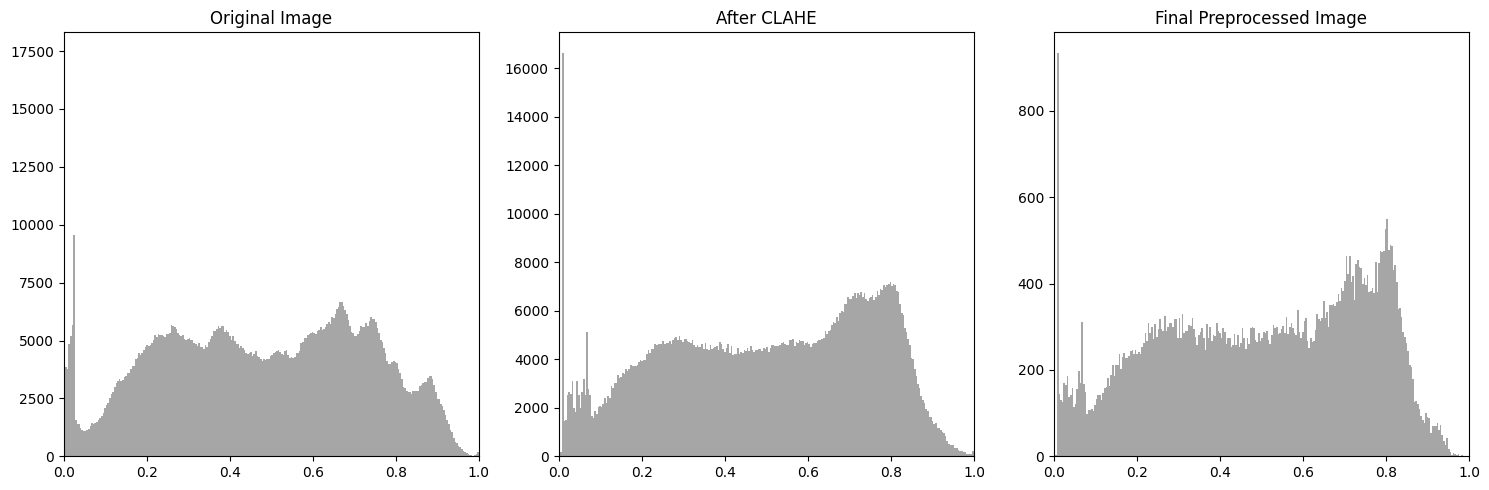

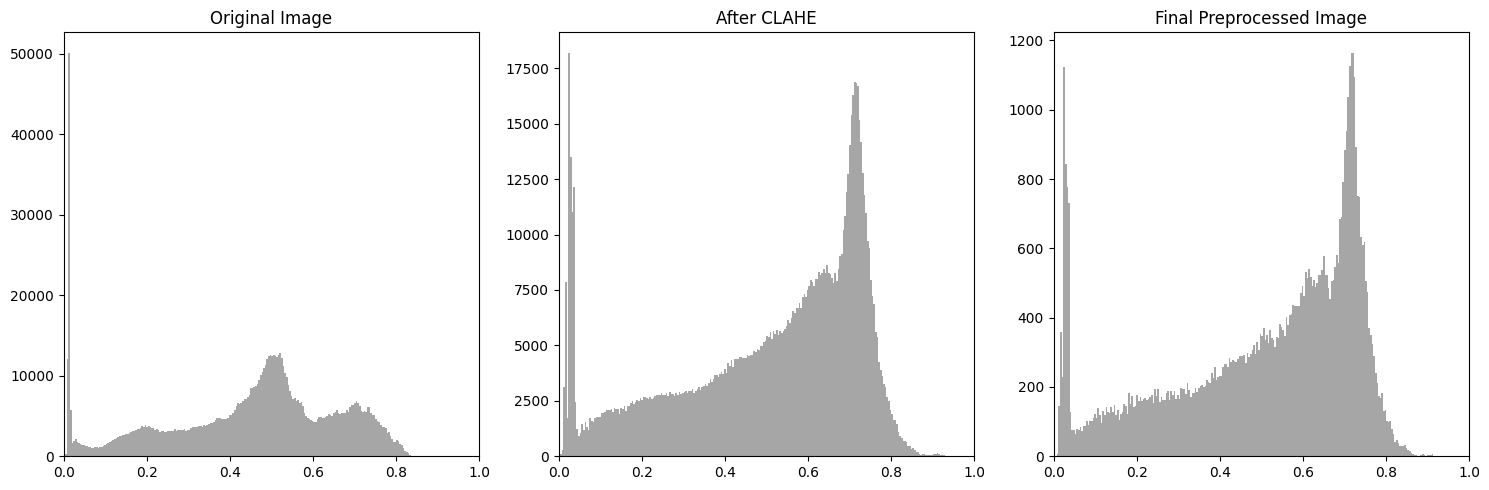

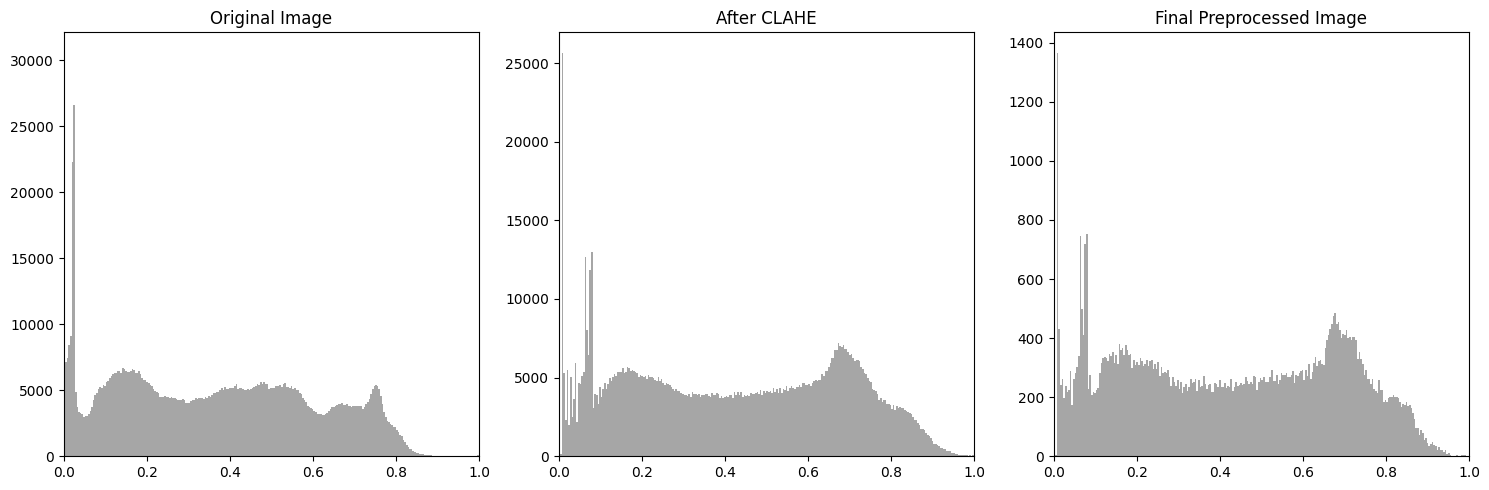

Processed 3 images.
Image shape: (256, 256, 1)


In [ ]:
# Choose specific images to preprocess and visualize histograms
sample_image_paths = selected_image_paths[:3]  # Select the first 3 images

# Function to plot histograms
def plot_histogram(image, title, ax):
    ax.hist(image.ravel(), bins=256, range=[0, 1], color='gray', alpha=0.7)
    ax.set_title(title)
    ax.set_xlim([0, 1])

# Preprocess function with histogram visualization
def preprocess_and_compare(image_path):
    # Load original image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    original_image_normalized = original_image / 255.0  # Normalize for histogram comparison

    # Preprocess the image
    enhanced_image = clahe(original_image)  # Enhance contrast
    blurred_image = gaussian_blur(enhanced_image)  # Apply Gaussian blur
    final_image = cv2.resize(blurred_image, RESIZE_DIM) / 255.0  # Resize and normalize

    # Plot histograms
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    plot_histogram(original_image_normalized, "Original Image", axs[0])
    plot_histogram(enhanced_image / 255.0, "After CLAHE", axs[1])
    plot_histogram(final_image, "Final Preprocessed Image", axs[2])
    plt.tight_layout()
    plt.show()

    return final_image

# Preprocess and visualize selected images
processed_images = np.array([preprocess_and_compare(p) for p in sample_image_paths])

# Expand dimensions for TensorFlow/Keras compatibility
processed_images = np.expand_dims(processed_images, axis=-1)

# Display dataset info
print(f"Processed {len(processed_images)} images.")
print(f"Image shape: {processed_images[0].shape}")


In [ ]:
# Define paths to save the data
save_dir = '/content/drive/My Drive/Imaging/preprocessed_data'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the preprocessed images and masks before splitting
np.save(os.path.join(save_dir, 'images.npy'), images)
np.save(os.path.join(save_dir, 'masks.npy'), masks)

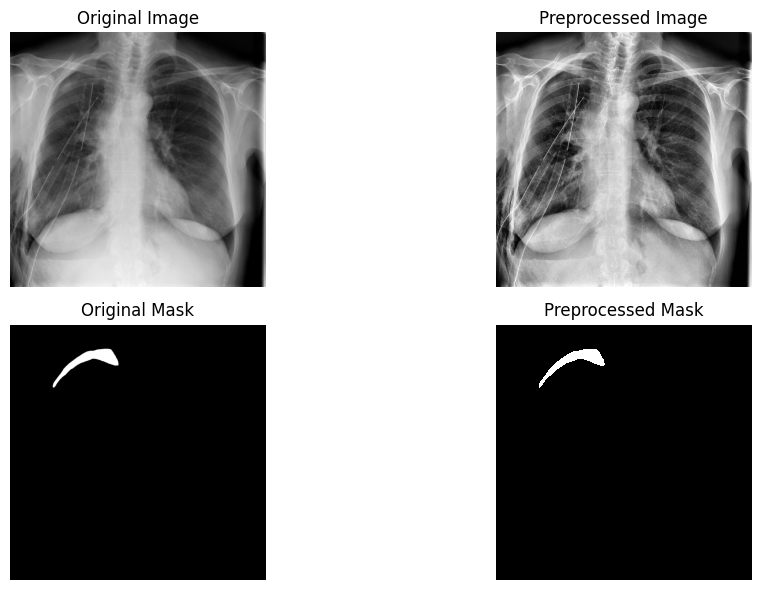

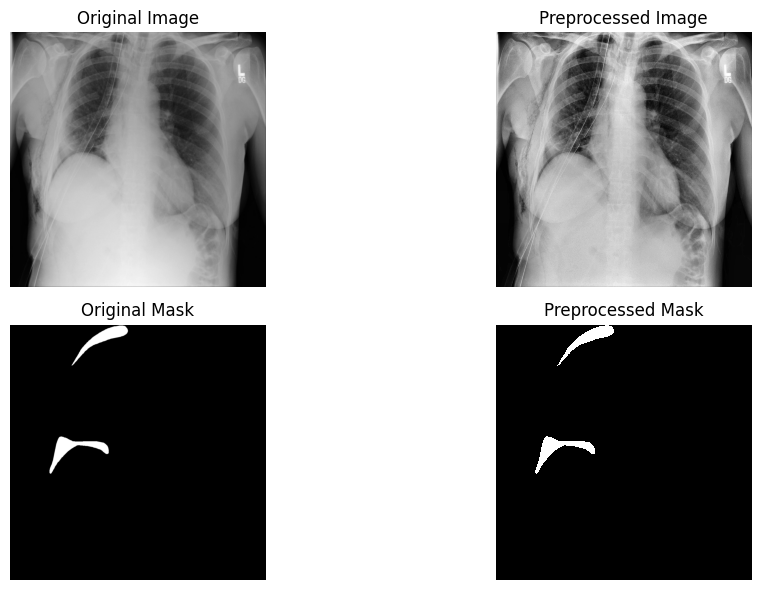

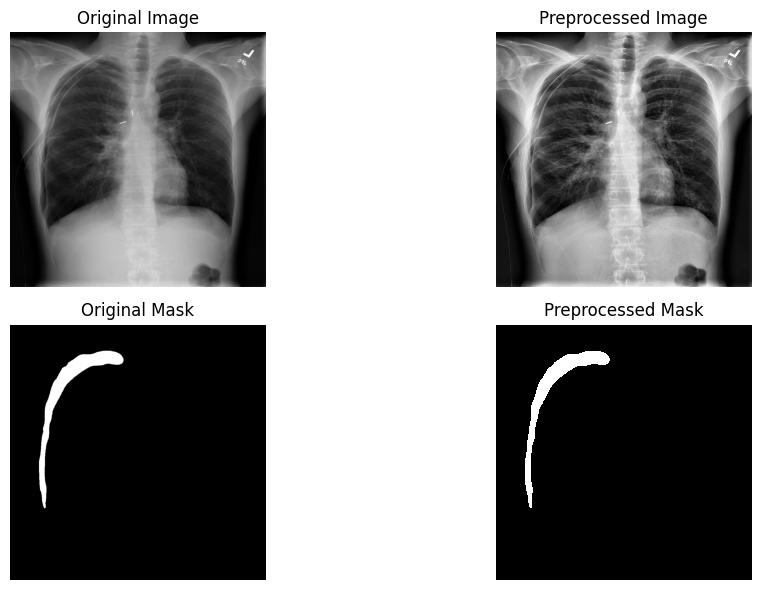

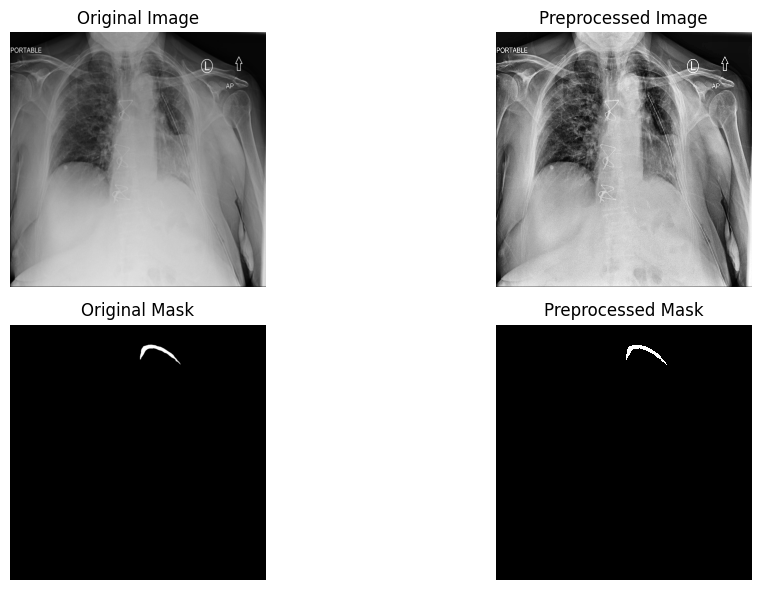

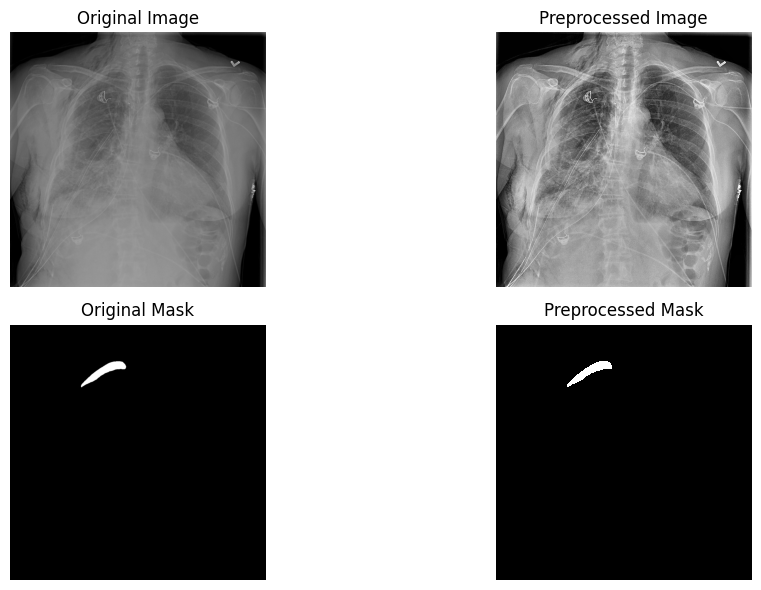

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2

# Select a few samples from the preprocessed dataset
num_samples = 5  # Number of samples to visualize

# Subset of selected image paths and mask paths
image_subset = selected_image_paths[:num_samples]
mask_subset = selected_mask_paths[:num_samples]

for i in range(num_samples):
    plt.figure(figsize=(12, 6))

    # Load the original image and mask (grayscale)
    original_image = cv2.imread(image_subset[i], cv2.IMREAD_GRAYSCALE)
    original_mask = cv2.imread(mask_subset[i], cv2.IMREAD_GRAYSCALE)

    # Preprocessed image and mask
    preprocessed_image = preprocess_image(image_subset[i])
    preprocessed_mask = preprocess_mask(mask_subset[i])

    # Plot the original image
    plt.subplot(2, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Plot the preprocessed image
    plt.subplot(2, 2, 2)
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title("Preprocessed Image")
    plt.axis('off')

    # Plot the original mask
    plt.subplot(2, 2, 3)
    plt.imshow(original_mask, cmap='gray')
    plt.title("Original Mask")
    plt.axis('off')

    # Plot the preprocessed mask
    plt.subplot(2, 2, 4)
    plt.imshow(preprocessed_mask, cmap='gray')
    plt.title("Preprocessed Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Splitting the data into test and train

In [ ]:
images = np.load('/content/drive/MyDrive/Imaging/images_dinaall.npy')
masks = np.load('/content/drive/MyDrive/Imaging/masks_dina.npy')

In [ ]:
from sklearn.model_selection import train_test_split

# Perform a 70-15-15 split
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the splits
print(f"Training set: {len(X_train)} images, {len(y_train)} masks")
print(f"Validation set: {len(X_val)} images, {len(y_val)} masks")
print(f"Testing set: {len(X_test)} images, {len(y_test)} masks")

Training set: 4115 images, 4115 masks
Validation set: 882 images, 882 masks
Testing set: 882 images, 882 masks


#Model Architecture

In [ ]:
from tensorflow.keras.regularizers import l2

# Define input shape based on your dataset
IMG_HEIGHT = images.shape[1]
IMG_WIDTH = images.shape[2]
IMG_CHANNELS = images.shape[3]

# Input layer
s = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# L2 regularization factor
l2_reg = 1e-4

# Contracting path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(s)
c1 = BatchNormalization()(c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2))(c1)
p1 = Dropout(0.2)(p1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(p1)
c2 = BatchNormalization()(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2))(c2)
p2 = Dropout(0.3)(p2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(p2)
c3 = BatchNormalization()(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2))(c3)
p3 = Dropout(0.3)(p3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(p3)
c4 = BatchNormalization()(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D((2, 2))(c4)
p4 = Dropout(0.4)(p4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(p4)
c5 = BatchNormalization()(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c5)
c5 = BatchNormalization()(c5)
p5 = MaxPooling2D(pool_size=(2, 2))(c5)
p5 = Dropout(0.5)(p5)

# Middle layer (Bottleneck)
c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(p5)
c6 = BatchNormalization()(c6)
c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.5)(c6)

# Expanding path
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c5])
c7 = Dropout(0.4)(u7)
c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c7)
c7 = BatchNormalization()(c7)
c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c4])
c8 = Dropout(0.3)(u8)
c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c8)
c8 = BatchNormalization()(c8)
c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c3])
c9 = Dropout(0.3)(u9)
c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c9)
c9 = BatchNormalization()(c9)
c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
            kernel_regularizer=l2(l2_reg))(c9)
c9 = BatchNormalization()(c9)

u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = concatenate([u10, c2])
c10 = Dropout(0.2)(u10)
c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
             kernel_regularizer=l2(l2_reg))(c10)
c10 = BatchNormalization()(c10)
c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
             kernel_regularizer=l2(l2_reg))(c10)
c10 = BatchNormalization()(c10)

u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = concatenate([u11, c1], axis=3)
c11 = Dropout(0.2)(u11)
c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
             kernel_regularizer=l2(l2_reg))(c11)
c11 = BatchNormalization()(c11)
c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
             kernel_regularizer=l2(l2_reg))(c11)
c11 = BatchNormalization()(c11)

# Output layer for binary segmentation (sigmoid activation)
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)

# Define model
model = Model(inputs=[s], outputs=[outputs])

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 256, 256, 16)   │            160 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 256, 256, 16)   │             64 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 256, 256, 16)   │             64 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128, 128, 16)   │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 128, 128, 32)   │            128 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 128, 128, 32)   │            128 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 64, 64, 32)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 64, 64, 32)     │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 64, 64, 64)     │            256 │ conv2d_27[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)   

 Total params: 7,787,345 (29.71 MB)

 Trainable params: 7,781,329 (29.68 MB)

 Non-trainable params: 6,016 (23.50 KB)

# Model Compiling and training

In [ ]:
# Dice Coefficient function
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Combined Loss
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + tf.keras.losses.binary_crossentropy(y_true, y_pred)

# Compile the model with the desired metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[
        dice_coefficient,  # Dice coefficient metric
        tf.keras.metrics.MeanIoU(num_classes=2)  # IoU metric
    ]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

# Define callbacks
callbacks = [
    EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='loss', save_best_only=True, verbose=1),
    CSVLogger('training_log.csv', append=True)
]

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=70,
    callbacks=callbacks
)


Epoch 1/70
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - dice_coefficient: 0.0124 - loss: 2.2083 - mean_io_u_1: 0.4771
Epoch 1: loss improved from inf to 2.06295, saving model to best_model.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 99s 247ms/step - dice_coefficient: 0.0124 - loss: 2.2078 - mean_io_u_1: 0.4770 - val_dice_coefficient: 0.0109 - val_loss: 1.7795 - val_mean_io_u_1: 0.4910 - learning_rate: 1.0000e-04
Epoch 2/70
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - dice_coefficient: 0.0123 - loss: 1.7848 - mean_io_u_1: 0.4772
Epoch 2: loss improved from 2.06295 to 1.73523, saving model to best_model.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - dice_coefficient: 0.0123 - loss: 1.7844 - mean_io_u_1: 0.4771 - val_dice_coefficient: 0.0110 - val_loss: 1.6016 - val_mean_io_u_1: 0.4910 - learning_rate: 1.0000e-04
Epoch 3/70
257/258 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - dice_coefficient: 0.0129 - loss: 1.6202 - mean_io_u_1: 0.4785
Epoch 3: loss improved from 1.73523 to 1.59155, saving model to 

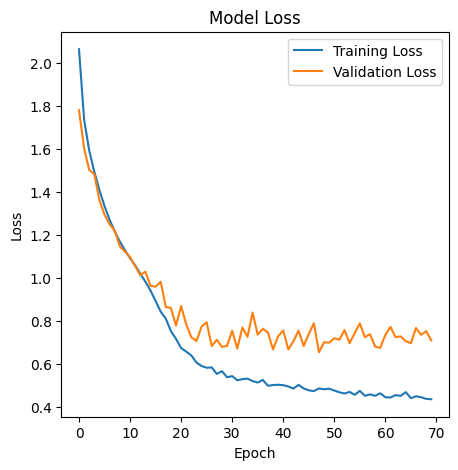

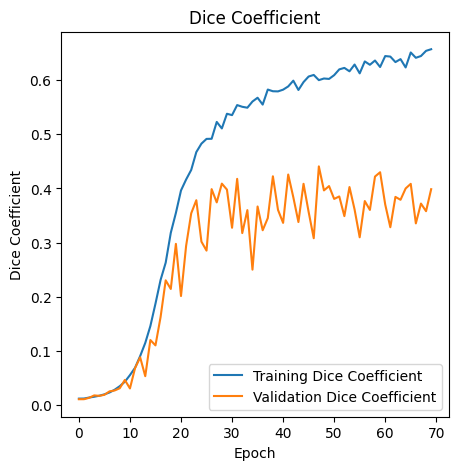

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Dice coefficient
plt.figure(figsize=(5, 5))
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

#Model Evaualtion


In [ ]:
# Function for morphological operations
def apply_morphological_operations(mask, operation="closing", kernel_size=5):

    # Convert mask to binary if needed
    binary_mask = (mask > 0.2).astype(np.uint8)

    # Create a structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Apply the selected morphological operation
    if operation == "dilation":
        refined_mask = cv2.dilate(binary_mask, kernel, iterations=1)
    elif operation == "erosion":
        refined_mask = cv2.erode(binary_mask, kernel, iterations=1)
    elif operation == "opening":
        refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    elif operation == "closing":
        refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    else:
        raise ValueError("Invalid operation type. Choose from 'dilation', 'erosion', 'opening', or 'closing'.")

    return refined_mask

In [ ]:
# Evaluate on test data
test_loss, test_dice, test_iou, *_ = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test Mean IoU: {test_iou:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 310ms/step - dice_coefficient: 0.5037 - loss: 0.5304 - mean_io_u: 0.4947
Test Loss: 0.5360
Test Dice Coefficient: 0.5009
Test Mean IoU: 0.4905


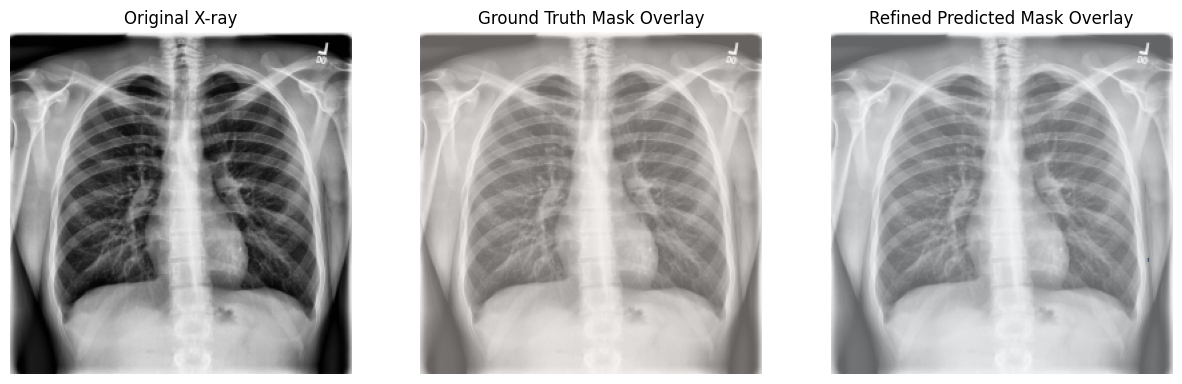

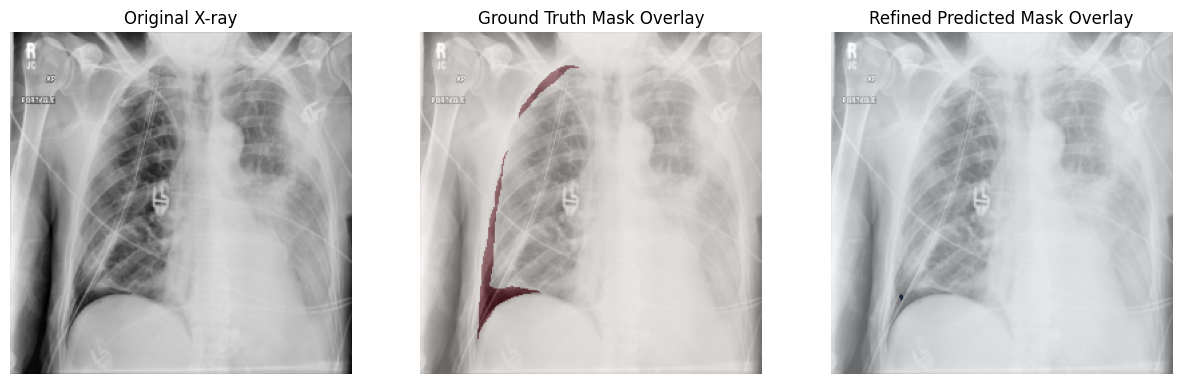

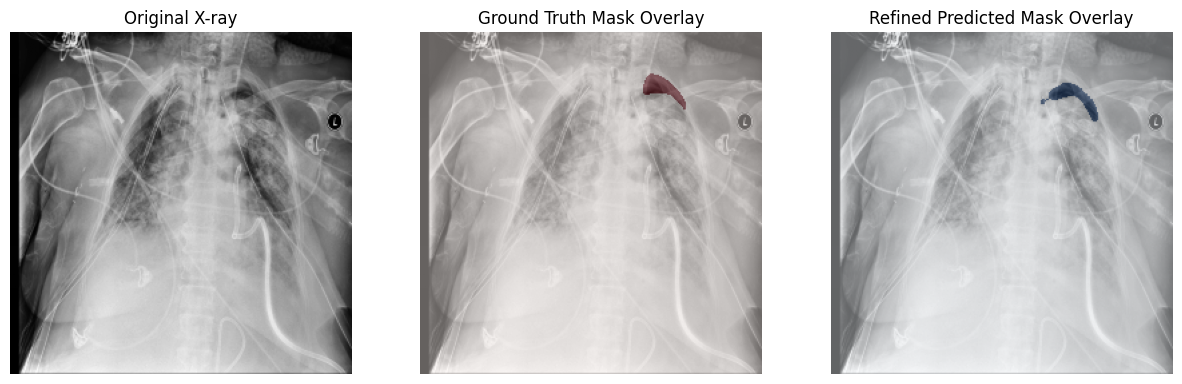

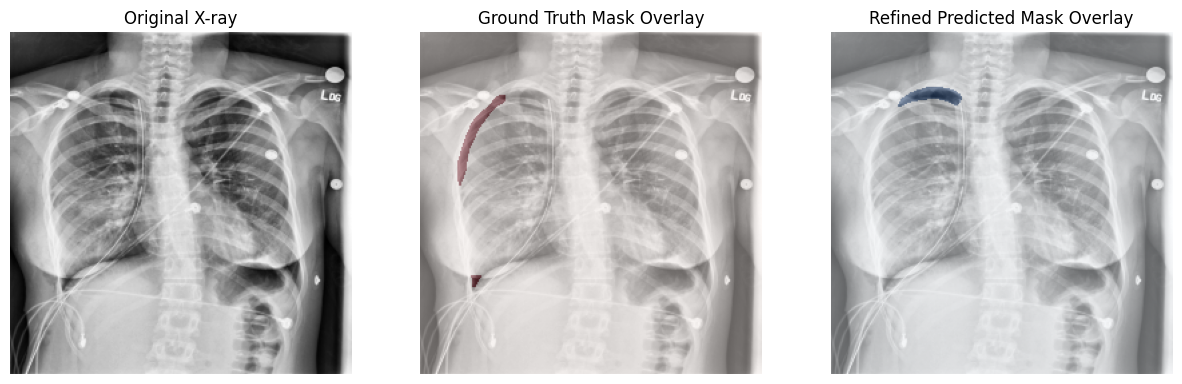

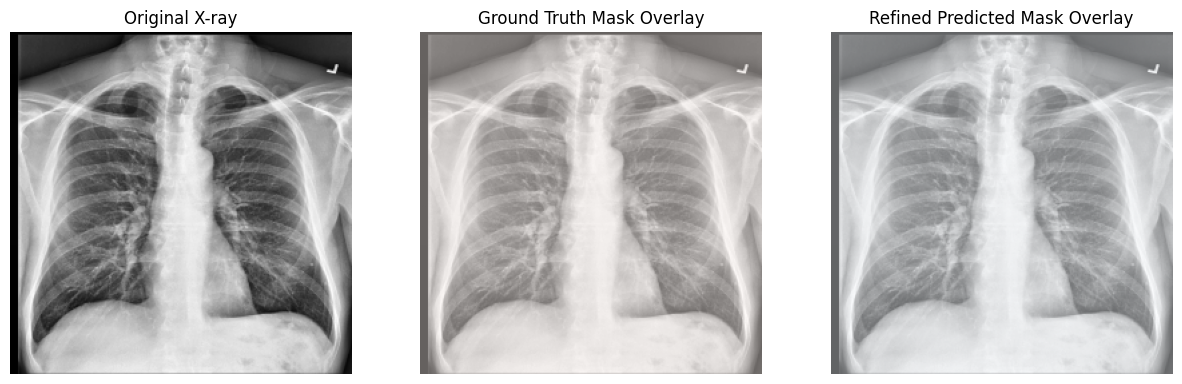

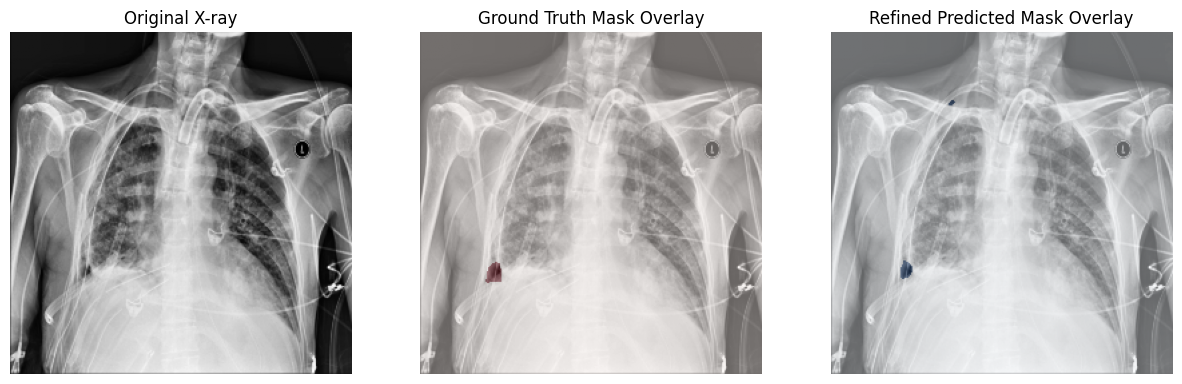

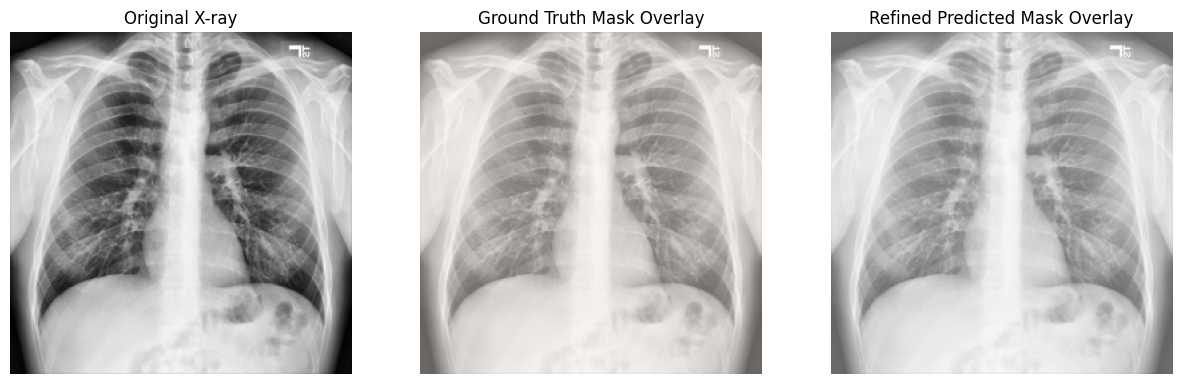

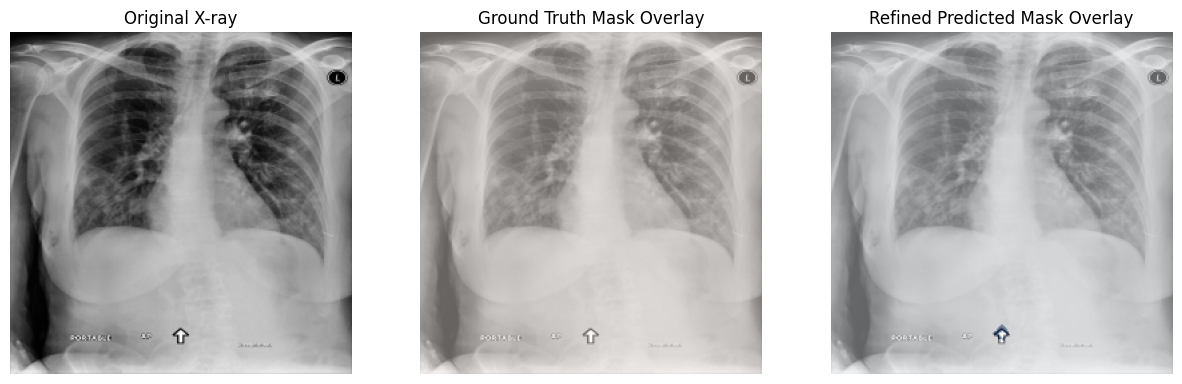

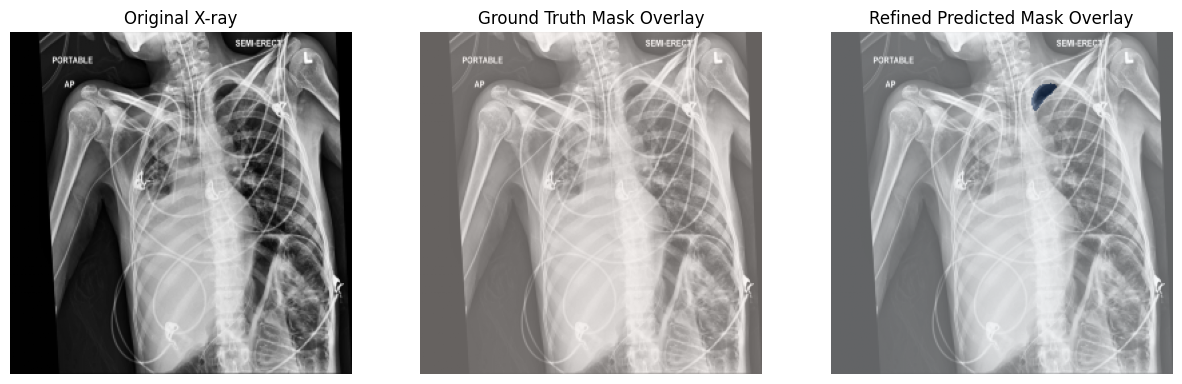

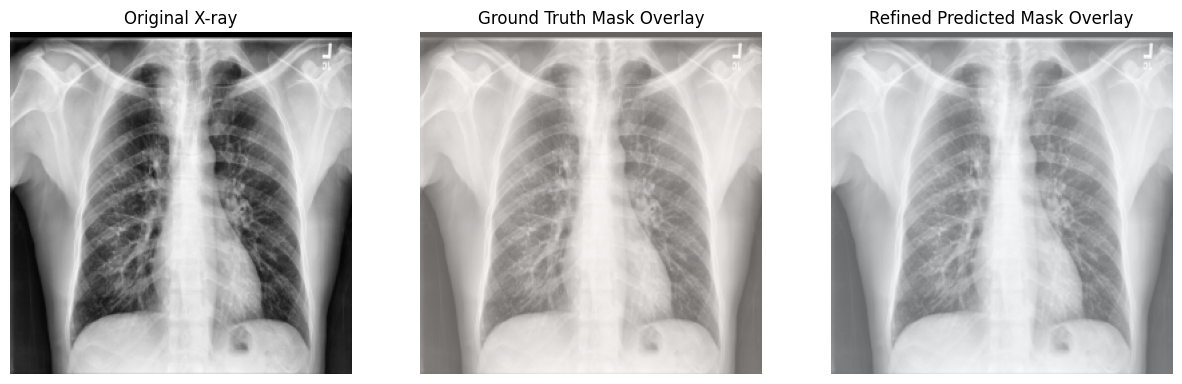

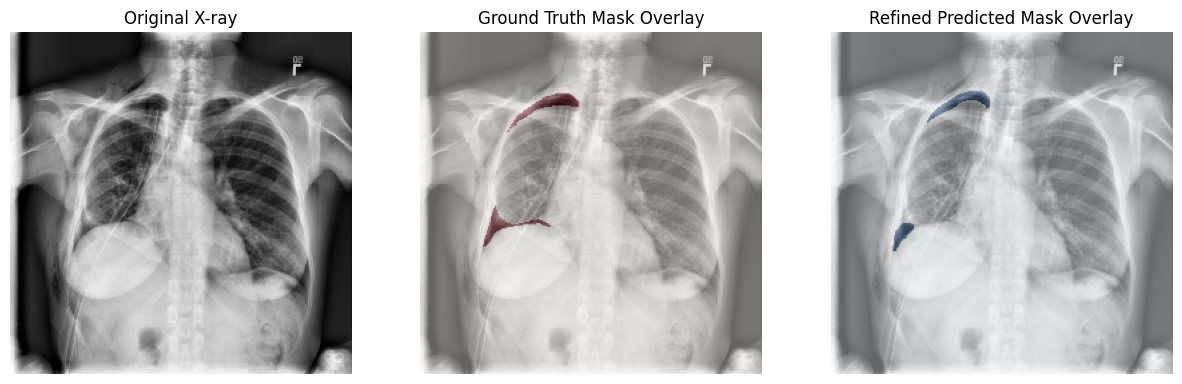

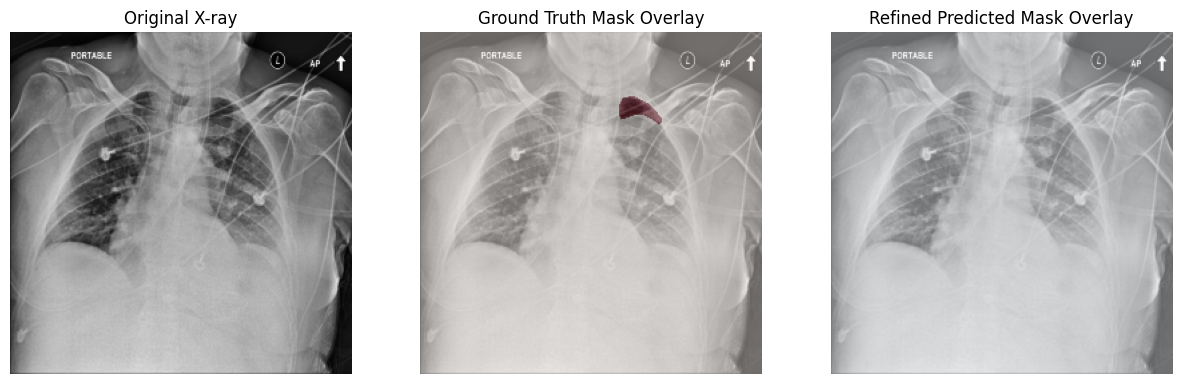

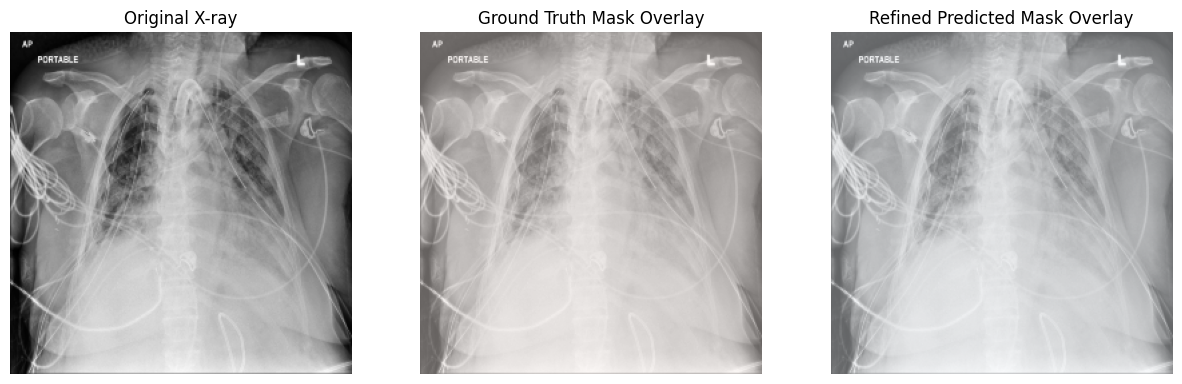

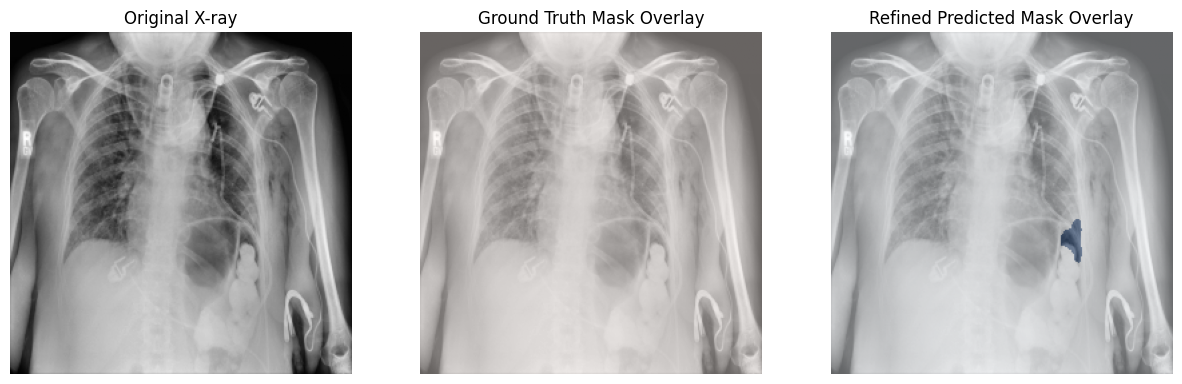

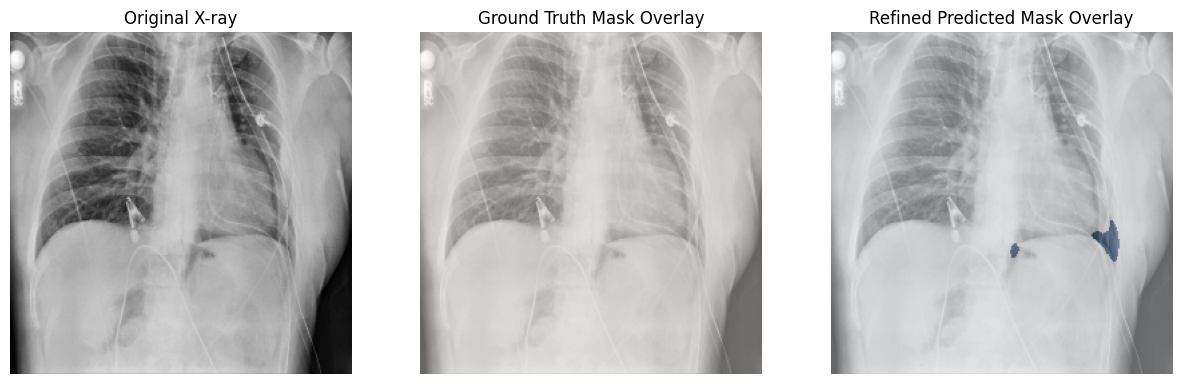

In [ ]:
# Visualization function
def visualize_overlay(image, ground_truth, prediction, threshold=0.5):
    # Apply threshold to the prediction
    predicted_mask = prediction > threshold

    plt.figure(figsize=(15, 5))

    # Original X-ray image
    plt.subplot(1, 3, 1)
    plt.title("Original X-ray")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Ground truth overlay
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask Overlay")
    plt.imshow(image, cmap='gray')
    plt.imshow(ground_truth, cmap='Reds', alpha=0.4)  # Overlay ground truth in red
    plt.axis('off')

    # Predicted mask overlay
    plt.subplot(1, 3, 3)
    plt.title("Refined Predicted Mask Overlay")
    plt.imshow(image, cmap='gray')
    plt.imshow(predicted_mask, cmap='Blues', alpha=0.4)  # Overlay prediction in blue
    plt.axis('off')

    plt.show()


# Visualize a few test samples
for i in range(15):  # Visualize the first 15 samples
    image = X_test[i].squeeze()  # Original X-ray image
    ground_truth = y_test[i].squeeze()  # Ground truth mask
    prediction = y_pred[i].squeeze()  # Predicted mask

    # Apply morphological postprocessing to the predicted mask
    refined_prediction = apply_morphological_operations(prediction, operation="closing", kernel_size=5)

    # Visualize the overlays
    visualize_overlay(image, ground_truth, refined_prediction)


In [ ]:
model.save('pneumothorax_segmentation_model.keras')
print("Model saved successfully!")


Model saved successfully!
